In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [2]:
# Load trajectories from pickle file
with open("trajectories.pickle", "rb") as f:
    trajectories = pickle.load(f)

In [3]:
# Monte Carlo evaluation for vπ(s)
def mc_value_function(trajectories, gamma=0.9):
    returns = defaultdict(list)
    V = {}

    for episode in trajectories:
        G = 0
        visited_states = set()
        for t in reversed(range(len(episode))):
            state, action, reward, next_state = episode[t]
            G = gamma * G + reward
            if state not in visited_states:
                returns[state].append(G)
                visited_states.add(state)

    for state in returns:
        V[state] = np.mean(returns[state])

    return V

In [4]:
# Monte Carlo evaluation for qπ(a, s)
def mc_action_value_function(trajectories, gamma=0.9):
    returns = defaultdict(lambda: defaultdict(list))
    Q = defaultdict(lambda: defaultdict(float))

    for episode in trajectories:
        G = 0
        visited_state_actions = set()
        for t in reversed(range(len(episode))):
            state, action, reward, next_state = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited_state_actions:
                returns[state][action].append(G)
                visited_state_actions.add((state, action))

    for state in returns:
        for action in returns[state]:
            Q[state][action] = np.mean(returns[state][action])

    return Q

In [5]:
# Compute the value functions
V_pi = mc_value_function(trajectories)
Q_pi = mc_action_value_function(trajectories)

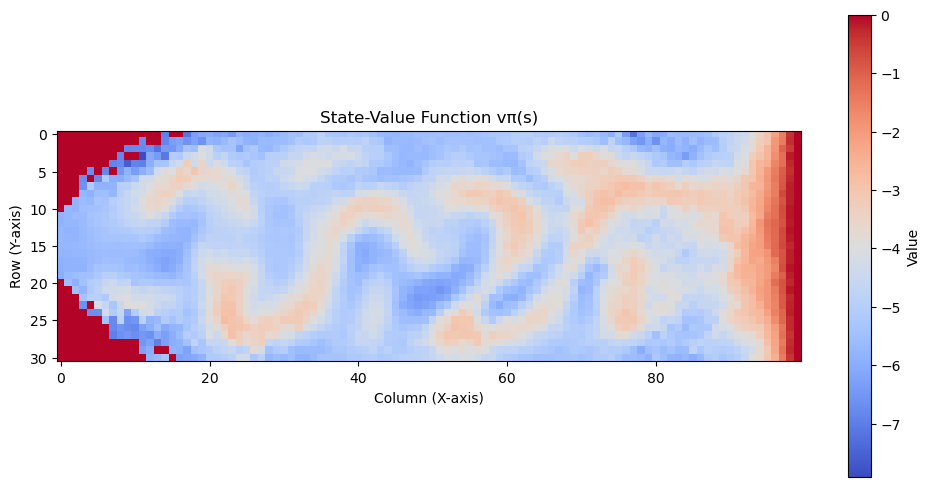

In [6]:
# Convert V_pi to a grid representation
grid_height = 31
grid_width = 100
V_grid = np.zeros((grid_height, grid_width))

for state, value in V_pi.items():
    row, col = state
    V_grid[row, col] = value

# Plot the state-value function vπ(s)
plt.figure(figsize=(12, 6))
plt.imshow(V_grid, cmap='coolwarm', origin='upper')
plt.colorbar(label="Value")
plt.title("State-Value Function vπ(s)")
plt.xlabel("Column (X-axis)")
plt.ylabel("Row (Y-axis)")
plt.show()

In [7]:
# Monte Carlo Policy Improvement: Extract the greedy policy
def mc_policy_improvement(Q):
    policy = {}

    for state in Q:
        # Choose the action with the highest value
        policy[state] = max(Q[state], key=Q[state].get)

    return policy

In [8]:
# Improve the policy
pi_prime = mc_policy_improvement(Q_pi)

In [9]:
# Compare the new policy with the old one
def is_policy_optimal(Q, pi_prime):
    for state in Q:
        best_action = max(Q[state], key=Q[state].get)
        if pi_prime[state] != best_action:
            return False  # Policy can still be improved
    return True

In [10]:
# Check if the policy is optimal
optimal = is_policy_optimal(Q_pi, pi_prime)
print(f"Is the improved policy optimal? {'Yes' if optimal else 'No'}")

Is the improved policy optimal? Yes


In [11]:
# Count how many states had a policy change
policy_changes = sum(1 for s in pi_prime if pi_prime[s] != max(Q_pi[s], key=Q_pi[s].get))
print(f"Number of states where policy changed: {policy_changes}")

Number of states where policy changed: 0


## 5 commenting on results

**MC Evaluation Result**
* The value function heatmap remained consistent with the terrain structure, indicating that the robot's movement was well-aligned with terrain difficulty.

**MC Policy Improvement Results**
* After applying MC policy improvement, the number of policy changes was 0, meaning the original policy was already optimal (or near-optimal).
* This suggests that the SpaceY trajectories were generated using a well-optimized policy, meaning further policy improvements were unnecessary.

**Are All Trajectories Equally Useful for MC Evaluation and Improvement?**
No, not all trajectories are equally useful. Here’s why:
1. Some Trajectories Provide More Information
    * Good trajectories (those that follow high-reward paths) are valuable because they reinforce optimal policy decisions.
    * Exploratory or suboptimal trajectories may not contribute much if they rarely visit useful states.
2. Coverage of the State Space
    * If some states are rarely visited in the given trajectories, their value estimates will be unreliable.
    * Monte Carlo methods rely on many visits to different states to get accurate estimates.
    * If trajectories don’t cover all important states, some parts of the value function may be inaccurate.
3. Finite Trajectories
    * Since the robot’s battery limits the number of steps, all trajectories are finite.
    * Some states might not be evaluated with long-term returns because episodes end early.

In [12]:
""" def mc_control(trajectories, gamma=0.9, epsilon=0.1, num_iterations=20):
    
    #Perform Monte Carlo Control with epsilon-greedy policy improvement.
    
    Q = defaultdict(lambda: defaultdict(float))  # Action-value function
    returns = defaultdict(lambda: defaultdict(list))  # Stores returns for state-action pairs
    policy = defaultdict(lambda: random.choice(range(5)))  # Initialize with random policy

    for _ in range(num_iterations):
        for episode in trajectories:
            G = 0
            visited_state_actions = set()

            # Reverse loop for First-Visit MC
            for t in reversed(range(len(episode))):
                state, action, reward, next_state = episode[t]
                G = gamma * G + reward

                if (state, action) not in visited_state_actions:
                    returns[state][action].append(G)
                    Q[state][action] = np.mean(returns[state][action])
                    visited_state_actions.add((state, action))

            # Policy Improvement: Epsilon-Greedy
            for state in Q:
                if np.random.rand() < epsilon:
                    policy[state] = random.choice(list(Q[state].keys()))  # Explore
                else:
                    policy[state] = max(Q[state], key=Q[state].get)  # Exploit best action

    return policy, Q """
    

' def mc_control(trajectories, gamma=0.9, epsilon=0.1, num_iterations=20):\n    \n    #Perform Monte Carlo Control with epsilon-greedy policy improvement.\n    \n    Q = defaultdict(lambda: defaultdict(float))  # Action-value function\n    returns = defaultdict(lambda: defaultdict(list))  # Stores returns for state-action pairs\n    policy = defaultdict(lambda: random.choice(range(5)))  # Initialize with random policy\n\n    for _ in range(num_iterations):\n        for episode in trajectories:\n            G = 0\n            visited_state_actions = set()\n\n            # Reverse loop for First-Visit MC\n            for t in reversed(range(len(episode))):\n                state, action, reward, next_state = episode[t]\n                G = gamma * G + reward\n\n                if (state, action) not in visited_state_actions:\n                    returns[state][action].append(G)\n                    Q[state][action] = np.mean(returns[state][action])\n                    visited_state_acti

In [13]:
def mc_control(trajectories, gamma=0.9, epsilon=0.1, max_iterations=20):
    Q = defaultdict(lambda: defaultdict(float))
    returns = defaultdict(lambda: defaultdict(list))
    policy = defaultdict(lambda: random.choice(range(5)))

    for i in range(max_iterations):
        old_policy = policy.copy()  # Track policy before updates
        for episode in trajectories:
            G = 0
            visited_state_actions = set()
            for t in reversed(range(len(episode))):
                state, action, reward, next_state = episode[t]
                G = gamma * G + reward
                if (state, action) not in visited_state_actions:
                    returns[state][action].append(G)
                    Q[state][action] = np.mean(returns[state][action])
                    visited_state_actions.add((state, action))

        # Policy Improvement with epsilon-greedy
        for state in Q:
            if np.random.rand() < epsilon:
                policy[state] = random.choice(list(Q[state].keys()))
            else:
                policy[state] = max(Q[state], key=Q[state].get)

        # Check convergence
        if policy == old_policy:
            print(f"Policy converged at iteration {i+1}")
            break

    return policy, Q

In [14]:
# Run MC Control
policy_mc, Q_mc = mc_control(trajectories)

In [15]:
# Check if policy has changed from the previous greedy policy
def compare_policies(old_policy, new_policy):
    changes = sum(1 for s in new_policy if old_policy.get(s, None) != new_policy[s])
    return changes

In [16]:
# Compare new MC control policy with original MC improvement policy
policy_changes = compare_policies(policy_mc, Q_mc)
print(f"Number of states where policy changed after MC Control: {policy_changes}")

Number of states where policy changed after MC Control: 2924


In [17]:
# Check if MC control resulted in an optimal policy
def is_policy_optimal(Q, policy):
    for state in Q:
        best_action = max(Q[state], key=Q[state].get)
        if policy[state] != best_action:
            return False  # Policy can still be improved
    return True

In [18]:
optimal_control = is_policy_optimal(Q_mc, policy_mc)
print(f"Is the policy after MC Control optimal? {'Yes' if optimal_control else 'No'}")

Is the policy after MC Control optimal? No


In [19]:
state_visit_count = {s: len(Q_mc[s]) for s in Q_mc}
print("Most visited states:", sorted(state_visit_count.items(), key=lambda x: -x[1])[:10])


Most visited states: [((np.int32(21), np.int32(98)), 5), ((np.int32(21), np.int32(97)), 5), ((np.int32(22), np.int32(97)), 5), ((np.int32(21), np.int32(96)), 5), ((np.int32(21), np.int32(95)), 5), ((np.int32(22), np.int32(94)), 5), ((np.int32(23), np.int32(93)), 5), ((np.int32(22), np.int32(93)), 5), ((np.int32(21), np.int32(92)), 5), ((np.int32(20), np.int32(92)), 5)]
